In [1]:
!git clone https://github.com/japolak/datahow-course-scripts.git
!pip install --upgrade scipy==1.7.3
!pip install --upgrade pyDOE2
!cd /content/datahow-course-scripts

Cloning into 'datahow-course-scripts'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 104 (delta 42), reused 80 (delta 21), pack-reused 0
Receiving objects: 100% (104/104), 2.01 MiB | 21.03 MiB/s, done.
Resolving deltas: 100% (42/42), done.
     |████████████████████████████████| 38.1 MB 1.8 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25539 sha256=4c69e44ccfde621681b58cd96ecce4749691d42831362b11229b2e8af27074ae
  Stored in director

In [11]:
import pandas as pd
import numpy as np
import scipy
import pyDOE2
import importlib  
import scipy.integrate
from matplotlib import pyplot as plt




# import custom modules
transformations = importlib.import_module("datahow-course-scripts.scripts.modules.transformations")
emulator = importlib.import_module("datahow-course-scripts.scripts.modules.emulator")

#notebook settings
pd.set_option('display.max_rows', None)


#owu = transformations.owu_from_csv("/content/mytable.csv")




# Experiment run generation

In [4]:
''' One Experiment run definition (variable = value)'''
# Model parameters
mu_g_max = 0.05;
mu_d_max = 0.025;
K_g_Glc  = 1;
K_I_Lac  = 30;
K_d_Lac  = 50;
k_Glc    = 0.04;
k_Lac    = 0.06;
k_Prod   = 1;
model_param = [mu_g_max,mu_d_max,K_g_Glc,K_I_Lac,K_d_Lac,k_Glc,k_Lac,k_Prod]

# Process parameters
feed_start = 3.0
feed_end = 12.0
Glc_feed_rate = 0.50
Glc_0 = 12.0
VCD_0 = 0.5
process_param = [feed_start,feed_end,Glc_feed_rate,Glc_0,VCD_0]


In [5]:
# Experiment run generation
t,y = emulator.predict_chrom_phase(model_param,process_param)
run_df = pd.DataFrame(y,columns=["X:VCD", "X:Glc", "X:Lac", "X:Titer"])
run_df


,X:VCD,X:Glc,X:Lac,X:Titer
0,0.500000,12.000000,0.000000,0.000000
1,1.471551,11.134896,1.303268,0.199102
2,3.869848,8.732356,4.925306,1.952155
3,7.907237,3.195349,13.306272,16.391986
4,12.101564,5.673504,27.739503,67.774204
5,14.782388,4.689308,47.397539,175.129793
6,14.749745,2.504735,68.981167,325.323861
7,12.664054,1.598027,88.865400,469.944302
8,10.290136,2.880981,105.346429,599.963298
9,8.330067,6.080447,118.708868,723.413889


#Generate Create a Design of Experiments

In this section, we first create a set of experiments using a Latin Hypercube design (LHD). This will be used to create an observation-wise unfolder (OWU) matrix that will be analyzed using Principle Component Analysis (PCA) and also in later scripts.

*Note: the created experimental design will be saved in the file "Experiments_TrainSet.mat" and used for comparison in the following lecture scripts.* 

For creating a DOE file, the following needs to be specified:
*   Number of experiments
*   Design limits
*   Errors 




In [73]:
''' DOE Dataset definition (variable = [lower bound, upper bound]) '''
# Model parameters
mu_g_max = [0.01, 0.10]
mu_d_max = [0.025, 0.075]
K_g_Glc = [1, 2]
K_g_Lac = [50, 80]
K_I_Lac = [30, 50]
K_d_Lac = [50, 80]
k_Glc = [0.04, 0.12]
k_Lac = [0.06, 0.15]
k_Prod = [1, 3]

# Process parameters
feed_start = [3, 6]
feed_end = [12.0, 16]
Glc_feed_rate = [0.50, 2]
Glc_0 = [12.0, 15.0]
VCD_0 = [0.3, 0.6]

var_lims = {"mu_g_max":mu_g_max,
    "mu_d_max": mu_d_max,
    "K_g_Glc" : K_g_Glc,
    "K_g_Lac" : K_g_Lac,
    "K_I_Lac" : K_I_Lac,
    "K_d_Lac" : K_d_Lac,
    "k_Glc" : k_Glc,
    "k_Lac" : k_Lac,
    "k_Prod" : k_Prod,
    "feed_start" : feed_start,
    "feed_end" : feed_end,
    "Glc_feed_rate" : Glc_feed_rate,
    "Glc_0" : Glc_0,
    "VCD_0" : VCD_0}


In [74]:
## Define errors
inputs_std_error = [0,0]  # absolute error on [VCD, Glc]
outputs_std_error = [0,0,0,0,0] # absolute error on [VCD, Glc, Lac, Titer]

In [75]:
## Define the number of experiments
num_runs = 10
## Define the filename for the dataset
filename = "mytable_train.csv"
# Generate DOE Dataset
owu = emulator.generate_data(var_lims, num_runs, filename)
owu = transformations.owu_from_csv("/content/"+filename)
owu

X:VCD         X:Glc       X:Lac      X:Titer
run timestamps                                                  
 0  0.0          0.450000  1.350000e+01    0.000000     0.000000
    1.0          1.408693  1.187831e+01    2.136868     0.613499
    2.0          3.628148  7.285377e+00    8.197172     6.236986
    3.0          5.094934  6.583614e-08   20.251589    33.572718
    4.0          3.617572 -1.257750e-09   31.217884    33.572718
    5.0          3.042765  1.222307e+01   39.073077    52.370665
    6.0          3.409265  3.600729e+01   47.249572    96.388295
    7.0          3.371678  5.940844e+01   55.919840   149.603029
    8.0          2.496128  8.362869e+01   63.511171   201.790335
    9.0          1.308790  1.100347e+02   68.230753   236.695544
    10.0         0.613295  1.382673e+02   70.551438   254.512960
    11.0         0.280147  1.674503e+02   71.624147   262.889778
    12.0         0.126824  1.970787e+02   72.111929   266.727776
    13.0         0.057207  2.269108e+02   72.332323   268.467743
    14.0         0.025767  2.568352e+02   72.431659   269.253134
 1  0.0          0.550000  1.316667e+01    0.000000     0.000000
    1.0          1.131109  1.127342e+01    1.263741     0.681187
    2.0          2.125152  7.555704e+00    3.748475     3.818311
    3.0          3.239441  1.256648e+00    7.995548    19.884802
    4.0          2.850412 -3.940898e-10   12.831025    24.484690
    5.0          2.299243 -1.619120e-10   16.848279    24.484690
    6.0          1.850147  2.991627e+00   20.029431    27.886000
    7.0          2.145692  2.035723e+01   23.126743    48.637293
    8.0          2.446222  3.696279e+01   26.719201    73.089586
    9.0          2.604190  5.300302e+01   30.685534   103.412344
    10.0         2.461576  6.898593e+01   34.688834   137.834504
    11.0         1.903960  8.579845e+01   38.139581   170.522115
    12.0         1.223503  1.041497e+02   40.566460   195.118747
    13.0         0.723679  1.239086e+02   42.056947   210.858214
    14.0         0.415629  1.446036e+02   42.924806   220.237810
 2  0.0          0.383333  1.283333e+01    0.000000     0.000000
    1.0          1.872819  1.101844e+01    1.936422     0.811676
    2.0          6.676188  3.449758e+00   10.039845    16.891483
    3.0          5.852548 -1.189426e-08   24.090973    37.122498
    4.0          3.600827 -3.804466e-09   33.639085    37.122498
    5.0          2.934388  1.239011e+01   39.683666    61.189155
    6.0          3.694377  3.601904e+01   46.467815   120.020899
    7.0          3.985147  5.851906e+01   54.445107   198.132749
    8.0          2.987316  8.158468e+01   61.818241   279.338548
    9.0          1.403931  1.074511e+02   66.212560   331.628652
    10.0         0.559232  1.356810e+02   68.094106   354.861046
    11.0         0.215786  1.649879e+02   68.830749   364.089158
    12.0         0.082559  1.947216e+02   69.113734   367.653249
    13.0         0.031494  2.012844e+02   69.221850   369.017607
    14.0         0.011998  2.012456e+02   69.263068   369.538191
 3  0.0          0.316667  1.383333e+01    0.000000     0.000000
    1.0          0.522491  1.330677e+01    1.436875     0.203691
    2.0          0.806048  1.246720e+01    3.728303     0.802635
    3.0          1.132325  1.123273e+01    7.098688     2.403305
    4.0          1.460179  4.457724e+01   11.610594     5.172044
    5.0          1.582870  8.458067e+01   17.043093     9.726566
    6.0          1.252994  1.247409e+02   22.047431    15.662939
    7.0          0.853747  1.653979e+02   25.700059    21.050811
    8.0          0.536687  2.065194e+02   28.089067    25.039499
    9.0          0.321670  2.479802e+02   29.555205    27.663261
    10.0         0.187547  2.896615e+02   30.421843    29.275399
    11.0         0.107641  3.314772e+02   30.923158    30.228249
    12.0         0.061231  3.733718e+02   31.209635    30.779257
    13.0         0.034659  4.153120e+02   31.372179    31.093963
    14.0         0.019565  4.572783e+02   31.464041    

In [76]:
owu.groupby("run")
owu.loc[1]
for run_ix,run in owu.groupby("run"):
  print(run_ix)


-1
0
1
2
3
4
5
6
7
9


## Plot one experiment

In [77]:
# Select run id to plot
selected_run_ix = 2

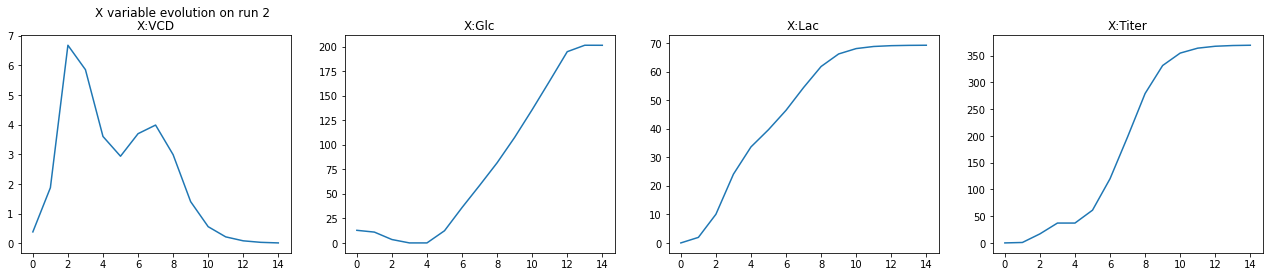

In [78]:
#[print(run) for ix,run in owu.groupby("run")]
columns = list(owu.columns)
num_vars=len(columns)
for run_ix,run in owu.groupby("run"):
    if run_ix==selected_run_ix or (type(selected_run_ix) is list and run_ix in selected_run_ix):
        fig, axs = plt.subplots(1,num_vars)
        fig.suptitle(f'X variable evolution on run {run_ix}')
        for plot_ix, col in enumerate(columns):
            axs[ plot_ix].plot(run.index.get_level_values("timestamps"),list(run[col].values))
            axs[ plot_ix].set_title(f'{col}')
            plt.subplots_adjust(right=3)

#Plot all experiments

In [79]:
list(run[col].values)

[0.0,
 2.9011498338347383,
 76.05533402965929,
 76.0553339453422,
 102.18866697611584,
 356.2669685257814,
 715.4690496490423,
 1130.63004378907,
 1484.6227707754488,
 1710.173309957669,
 1837.9655308737688,
 1907.7128083242224,
 1945.14211017581,
 1965.0554889213367,
 1975.603746381352]

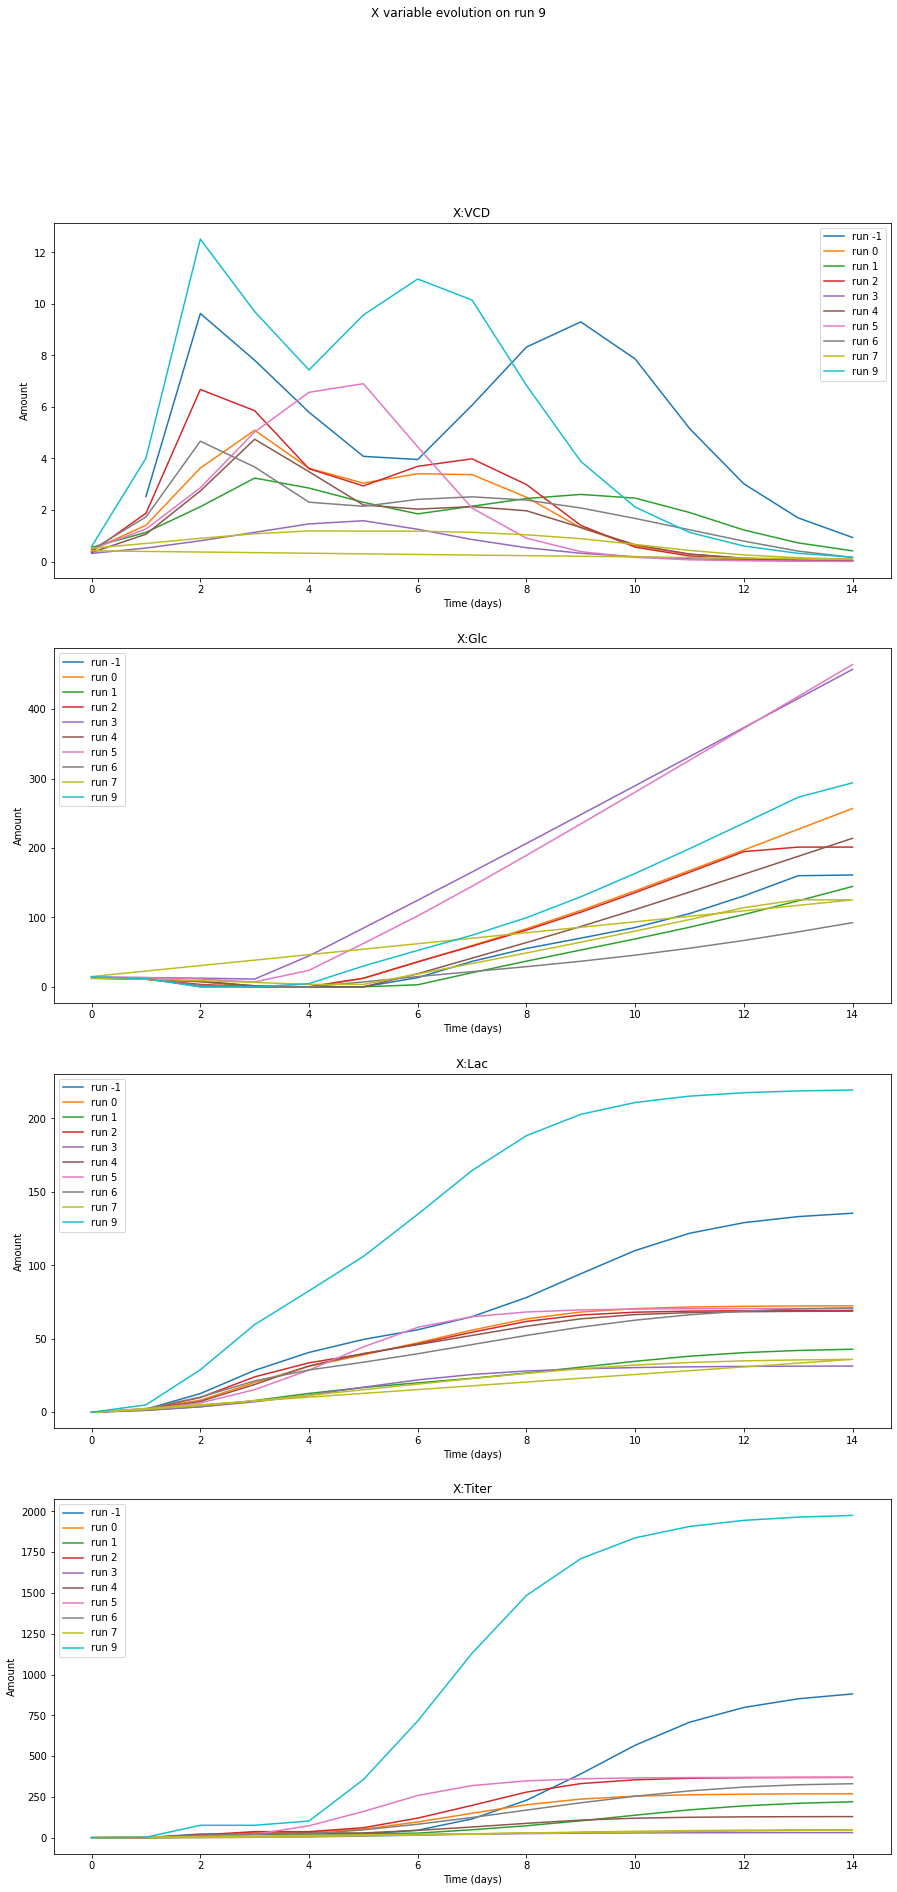

In [80]:
fig, axs = plt.subplots(num_vars,figsize=(15,30))
units_list =[""]
for run_ix,run in owu.groupby("run"):
    fig.suptitle(f'X variable evolution on run {run_ix}')
    for plot_ix, col in enumerate(columns):
        axs[ plot_ix].plot(run.index.get_level_values("timestamps"),list(run[col].values),label=f'run {run_ix}')
        axs[ plot_ix].set_title(f'{col}')
        #plt.subplots_adjust(right=3)
        axs[ plot_ix].set_xlabel("Time (days)")
        axs[ plot_ix].set_ylabel("Amount")
        axs[plot_ix].legend(loc="best")


In [ ]:
# Color by run by
color_run = "run_ix",

Options: 
# run_ix: Color by run id
# Titer: Color by final Titer
# VCD: Color by final VCD

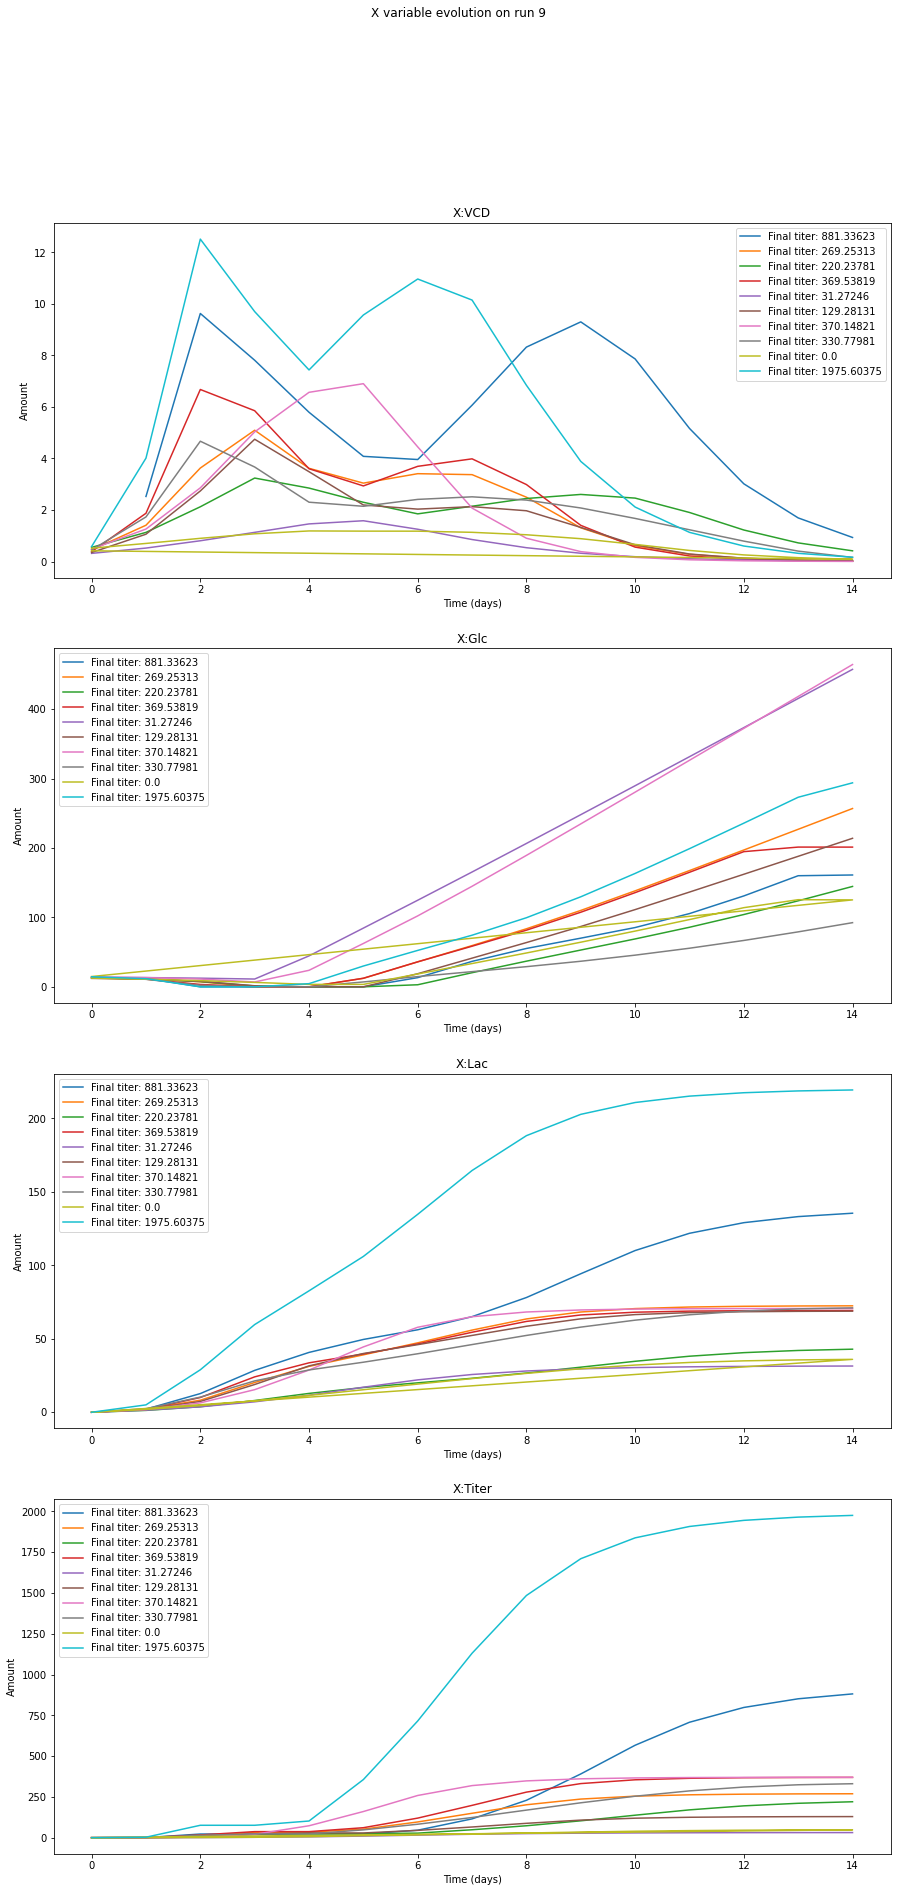

In [81]:
fig, axs = plt.subplots(num_vars,figsize=(15,30))
units_list =[""]
for run_ix,run in owu.groupby("run"):
    fig.suptitle(f'X variable evolution on run {run_ix}')
    for plot_ix, col in enumerate(columns):
        axs[ plot_ix].plot(run.index.get_level_values("timestamps"),list(run[col].values),label=f'Final titer: {round(run["X:Titer"].iloc[-1],5)}')
        axs[ plot_ix].set_title(f'{col}')
        #plt.subplots_adjust(right=3)
        axs[ plot_ix].set_xlabel("Time (days)")
        axs[ plot_ix].set_ylabel("Amount")
        axs[plot_ix].legend(loc="best")
